# Lake model continued - sensitivity analysis

In the previous week you used the lake problem as a means of getting acquainted with the workbench. In this assignment we will continue with the lake problem, focussing explicitly on using it for open exploration. You can use the second part of the [open exploration tutorial](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html) for help.

**It is paramount that you are using the lake problem with 100 decision variables, rather than the one found on the website with the separate anthropogenic release decision**

There is substantial support in the ema_workbench for global sensitivity. For this, the workbench relies on [SALib](https://salib.readthedocs.io/en/latest/) and feature scoring which is a machine learning alternative for global sensitivity analysis.

## 1. SOBOL
1. Apply Sobol with 3 separate release policies (0, 0.05, and 0.1) and analyse the results for each release policy separately focusing on the reliability objective. Do the sensitivities change depending on the release policy? Can you explain why or why not?

*hint: you can use sobol sampling for the uncertainties, and set policies to a list with the 3 different release policies. Next, for the analysis using logical indexing on the experiment.policy column you can select the results for each separate release policy and apply sobol to each of the three separate release policies. If this sounds too complicated, just do it on each release policy separately.*

In [1]:
from lakemodel_function import lake_problem

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
from ema_workbench import (Model, RealParameter, ScalarOutcome)

#instantiate the model
lake_model = Model('lakeproblem', function=lake_problem)
lake_model.time_horizon = 100 # used to specify the number of timesteps

#specify uncertainties
lake_model.uncertainties = [RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('delta', 0.93, 0.99)]

# set levers, one for each time step
lake_model.levers = [RealParameter(f"l{i}", 0, 0.1) for i in 
                     range(lake_model.time_horizon)] # we use time_horizon here

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P'),
                       ScalarOutcome('utility'),
                       ScalarOutcome('inertia'),
                       ScalarOutcome('reliability')]

In [3]:
from ema_workbench import Policy

policies = [Policy('0', **{l.name:0 for l in lake_model.levers}),
            Policy('0.05', **{l.name:0.05 for l in lake_model.levers}),
            Policy('0.1', **{l.name:0.1 for l in lake_model.levers})]

In [ ]:
from ema_workbench import MultiprocessingEvaluator, ema_logging
from ema_workbench import Samplers
from ema_workbench.em_framework import get_SALib_problem

ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(lake_model, n_processes=-2) as evaluator:
    experiments, results = evaluator.perform_experiments(2048, policies, uncertainty_sampling=Samplers.SOBOL)

In [ ]:
problem = get_SALib_problem(lake_model.uncertainties)
problem

In [ ]:
problem.names

In [6]:
print(experiments.policy.unique())

['0', '0.05', '0.1']
Categories (3, object): ['0', '0.05', '0.1']


In [7]:
logical = experiments.policy == '0.1'
y = results['reliability']
print(len(y))
hoi = results['reliability'][logical]
print(results)
print(len(hoi))


73728
{'max_P': array([0.06557999, 0.05443702, 0.06552891, ..., 4.85761351, 4.82687347,
       4.82639353]), 'utility': array([0.        , 0.        , 0.        , ..., 0.73998699, 0.73998699,
       0.73998699]), 'inertia': array([0., 0., 0., ..., 0., 0., 0.]), 'reliability': array([1.    , 1.    , 1.    , ..., 0.0601, 0.05  , 0.05  ])}
24576


In [8]:
from SALib.analyze.sobol import analyze

sobol_results = {}
for policy in experiments.policy.unique():
    logical = experiments.policy == policy
    y = results['reliability'][logical]
    indices = analyze(problem, y)
    sobol_results[policy] = indices

C:\Users\jaspe\PycharmProjects\MBDM assignments\MBDM-project\.venv\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

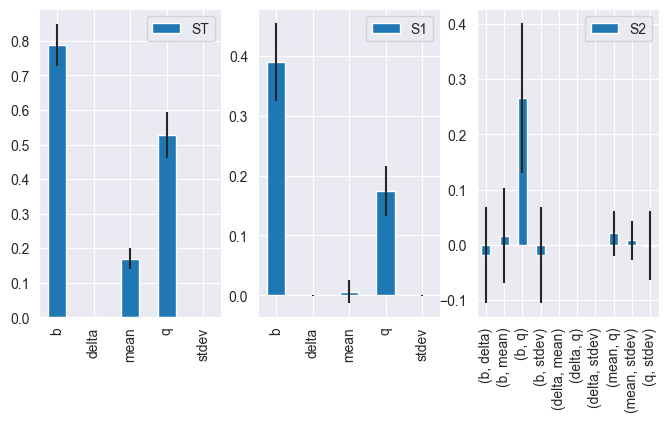

In [9]:
fig, axes = plt.subplots(1,3)
fig.set_size_inches(8, 4)
indices.plot(ax=axes)

## 2. Feature scoring
Repeat the above analysis for the 3 release policies but now with extra trees [feature scoring](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/feature_scoring.html) and for all outcomes of interest. As a bonus, use the sobol experiment results as input for extra trees, and compare the results with those resulting from latin hypercube sampling.

*hint: you can use [seaborn heatmaps](https://seaborn.pydata.org/generated/seaborn.heatmap.html) for a nice figure of the results. See also the [features scoring](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html#feature-scoring) section of the tutorial.*


In [10]:
from ema_workbench.analysis import feature_scoring

cleaned_experiments = experiments.drop(columns=[l.name for l in lake_model.levers])

scores = feature_scoring.get_feature_scores_all(cleaned_experiments,results)

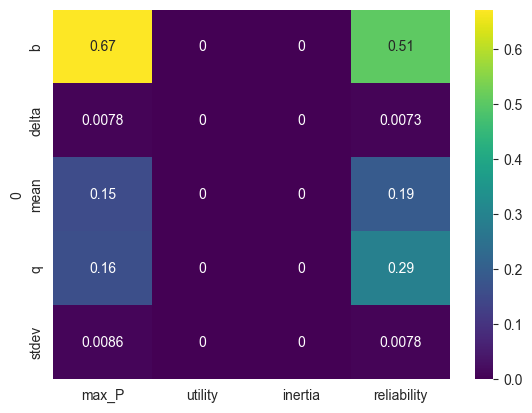

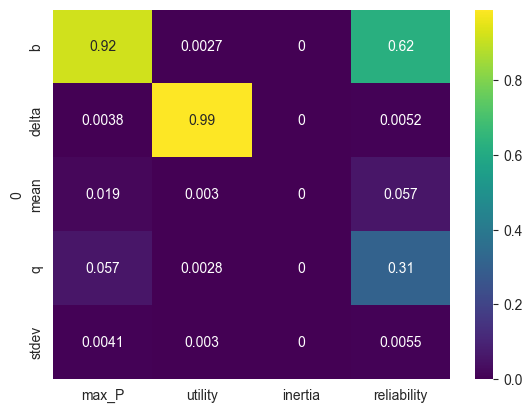

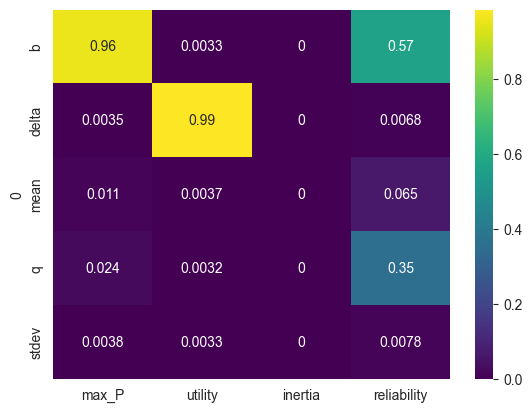

In [11]:
cleaned_experiments = experiments.drop(columns=[l.name for l in lake_model.levers])

for policy in experiments.policy.unique():
    logical = experiments.policy == policy
    subset_results = {k:v[logical] for k,v in results.items()}
    scores = feature_scoring.get_feature_scores_all(cleaned_experiments[logical],
                                                   subset_results)
    sns.heatmap(scores, annot=True, cmap='viridis')
    plt.show()